<a href="https://colab.research.google.com/github/yogendra1109/Machine_Hack_Air_PM10_Estimator/blob/main/Air_Quality_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = '/content/drive/My Drive/Hackathon/Dataset-2/Training.csv'
test_path = '/content/drive/My Drive/Hackathon/Dataset-2/Test.csv'
sample_path = '/content/drive/My Drive/Hackathon/Dataset-2/Submission.csv'


In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_df = pd.read_csv(sample_path)

In [5]:
train_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,DateTime,Date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,2013-03-01 00:00:00,2013-03-01
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,2013-03-01 01:00:00,2013-03-01
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,2013-03-01 02:00:00,2013-03-01
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,2013-03-01 03:00:00,2013-03-01
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,2013-03-01 04:00:00,2013-03-01


In [6]:
test_df.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,DateTime,Date
0,2013,3,1,18,11.0,8.0,20.0,500.0,70.0,3.1,1027.4,-18.4,0.0,NNE,2.1,01/03/13 18:00,01/03/13
1,2013,3,2,13,25.0,20.0,57.0,700.0,39.0,3.3,1025.7,-16.4,0.0,W,1.5,02/03/13 13:00,02/03/13
2,2013,3,3,13,98.0,50.0,81.0,1200.0,33.0,16.0,1011.5,-13.5,0.0,W,5.9,03/03/13 13:00,03/03/13
3,2013,3,4,4,7.0,14.0,NaN,400.0,42.0,6.0,1018.0,-11.6,0.0,NNW,1.0,04/03/13 4:00,04/03/13
4,2013,3,5,9,114.0,114.0,92.0,2899.0,84.0,7.7,1012.8,-8.4,0.0,NNE,1.5,05/03/13 9:00,05/03/13


In [7]:
sample_df.head()

,PM10
0,0
1,0
2,0
3,0
4,0


In [8]:
cols_to_drop = ['No','DateTime','Date']

In [9]:
train_df = train_df.drop(cols_to_drop,axis=True)

In [10]:
drop_col = ['DateTime','Date']

In [11]:
test_df = test_df.drop(drop_col,axis=True)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33043 entries, 0 to 33042
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    33043 non-null  int64  
 1   month   33043 non-null  int64  
 2   day     33043 non-null  int64  
 3   hour    33043 non-null  int64  
 4   PM2.5   32833 non-null  float64
 5   PM10    33043 non-null  float64
 6   SO2     32767 non-null  float64
 7   NO2     32692 non-null  float64
 8   CO      31965 non-null  float64
 9   O3      32005 non-null  float64
 10  TEMP    33023 non-null  float64
 11  PRES    33023 non-null  float64
 12  DEWP    33023 non-null  float64
 13  RAIN    33023 non-null  float64
 14  wd      32964 non-null  object 
 15  WSPM    33029 non-null  float64
dtypes: float64(11), int64(4), object(1)
memory usage: 4.0+ MB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    1303 non-null   int64  
 1   month   1303 non-null   int64  
 2   day     1303 non-null   int64  
 3   hour    1303 non-null   int64  
 4   PM2.5   1297 non-null   float64
 5   SO2     1293 non-null   float64
 6   NO2     1284 non-null   float64
 7   CO      1256 non-null   float64
 8   O3      1262 non-null   float64
 9   TEMP    1303 non-null   float64
 10  PRES    1303 non-null   float64
 11  DEWP    1303 non-null   float64
 12  RAIN    1303 non-null   float64
 13  wd      1301 non-null   object 
 14  WSPM    1303 non-null   float64
dtypes: float64(10), int64(4), object(1)
memory usage: 152.8+ KB


In [14]:
print('Are there any duplicated values in our data ? : {}\n'.format(train_df.duplicated().any()))
print('The total number of null values in each colum:')
display(train_df.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


year        0
month       0
day         0
hour        0
PM2.5     210
PM10        0
SO2       276
NO2       351
CO       1078
O3       1038
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         79
WSPM       14
dtype: int64

In [15]:
print('Are there any duplicated values in our data ? : {}\n'.format(test_df.duplicated().any()))
print('The total number of null values in each colum:')
display(test_df.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


year      0
month     0
day       0
hour      0
PM2.5     6
SO2      10
NO2      19
CO       47
O3       41
TEMP      0
PRES      0
DEWP      0
RAIN      0
wd        2
WSPM      0
dtype: int64

In [16]:
train_df.wd.mode()

0    NE
Name: wd, dtype: object

In [17]:
test_df.wd.mode()

0    NE
Name: wd, dtype: object

In [18]:
# Fill missing values for numerical columns only
numeric_cols = train_df.select_dtypes(include=['number']).columns
train_df[numeric_cols] = train_df[numeric_cols].fillna(value=train_df[numeric_cols].mean())

# Replace missing values for wind direction with the modal value
train_df.wd.fillna(value='NE',inplace=True)

# Check for remaining missing values
train_df.isnull().any()

year     False
month    False
day      False
hour     False
PM2.5    False
PM10     False
SO2      False
NO2      False
CO       False
O3       False
TEMP     False
PRES     False
DEWP     False
RAIN     False
wd       False
WSPM     False
dtype: bool

In [19]:
# Fill missing values for numerical columns only
numeric_cols = test_df.select_dtypes(include=['number']).columns
test_df[numeric_cols] = test_df[numeric_cols].fillna(value=test_df[numeric_cols].mean())

# Replace missing values for wind direction with the modal value
test_df.wd.fillna(value='NE',inplace=True)

# Check for remaining missing values
test_df.isnull().any()

year     False
month    False
day      False
hour     False
PM2.5    False
SO2      False
NO2      False
CO       False
O3       False
TEMP     False
PRES     False
DEWP     False
RAIN     False
wd       False
WSPM     False
dtype: bool

In [20]:
years = train_df['year'].values
months = train_df['month'].values
days = train_df['day'].values
hours = train_df['hour'].values
full_date = []

for i in range(train_df.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
train_df = pd.concat([dates,train_df],axis=1)

train_df.head()

,date,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


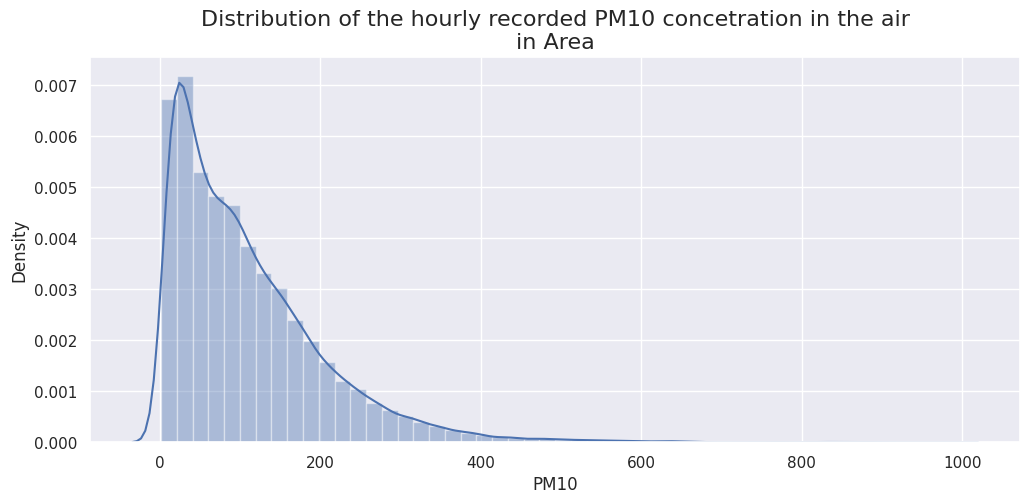

In [21]:
plt.figure(figsize=(12,5))
sns.distplot(train_df['PM10'],bins=50)
plt.title('Distribution of the hourly recorded PM10 concetration in the air\nin Area',
          fontsize=16)
plt.show()

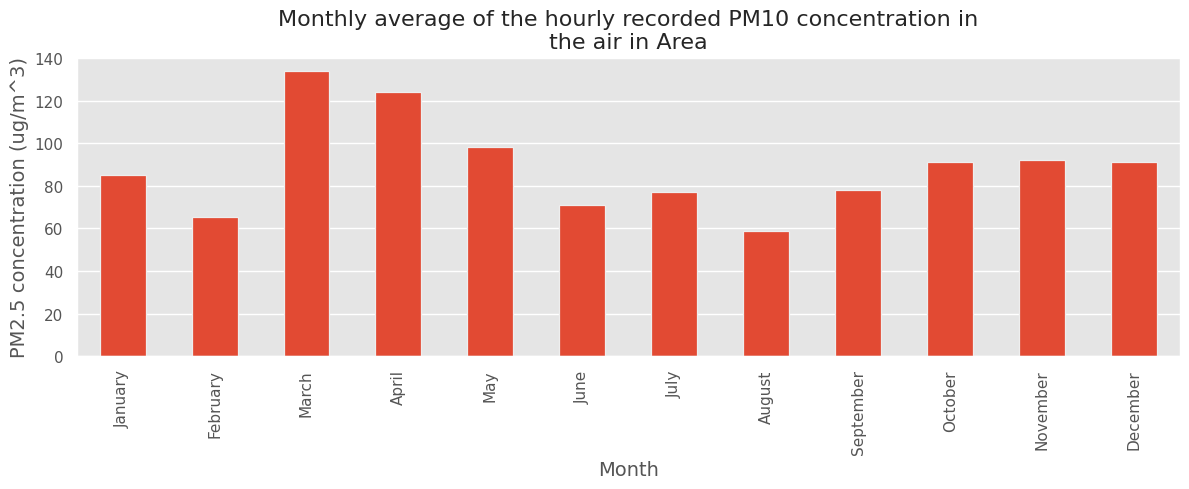

In [22]:
monthly_data = train_df[['month','PM10']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM10 concentration in\nthe air in Area',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

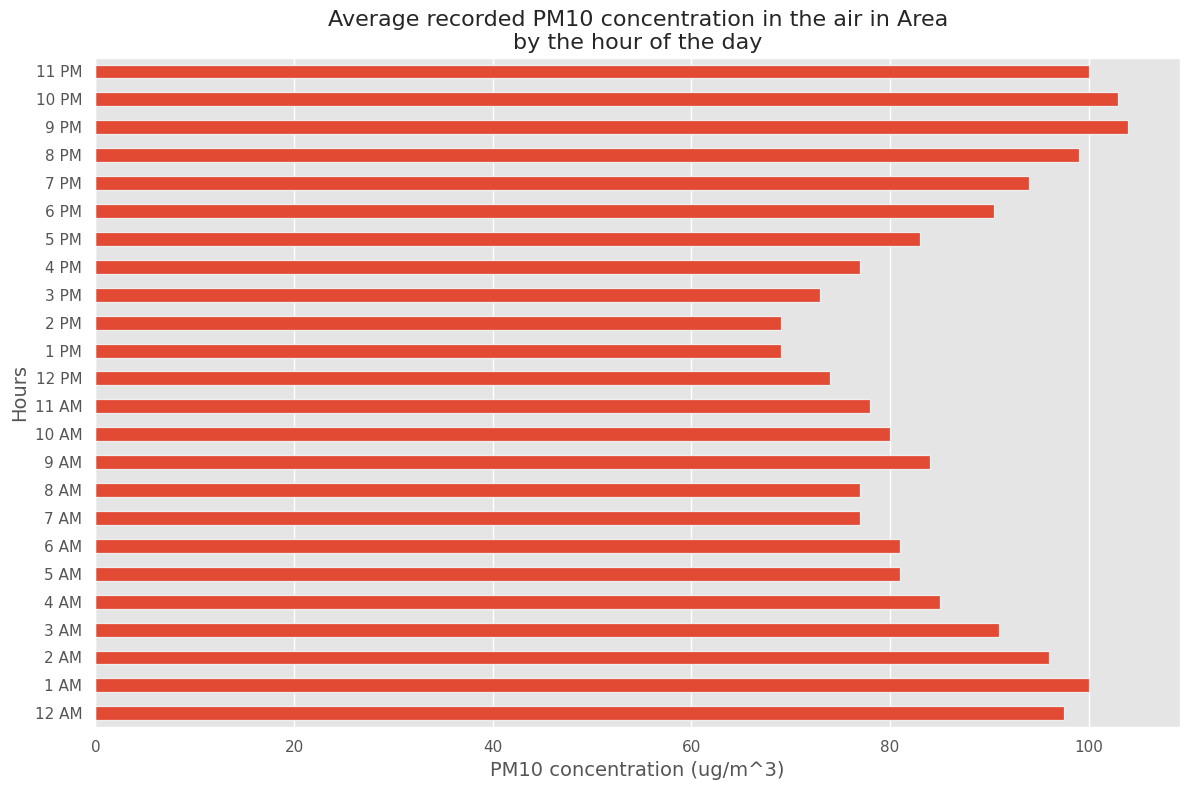

In [23]:
hourly_data = train_df[['hour','PM10']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)

hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM10 concentration in the air in Area\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

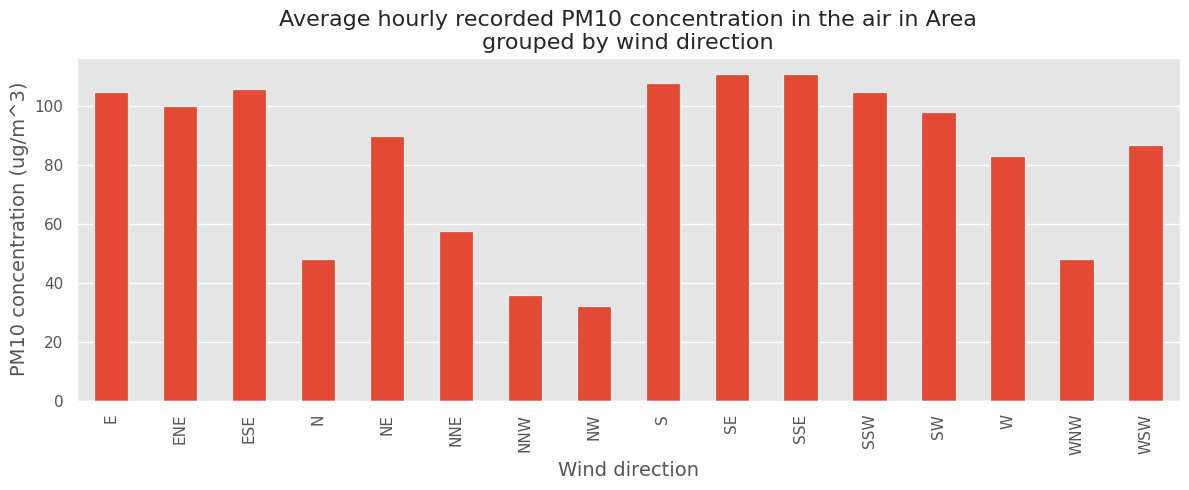

In [24]:
wind_dir = train_df[['wd','PM10']]
wind_dir = wind_dir.groupby('wd').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM10 concentration in the air in Area\ngrouped by wind direction',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

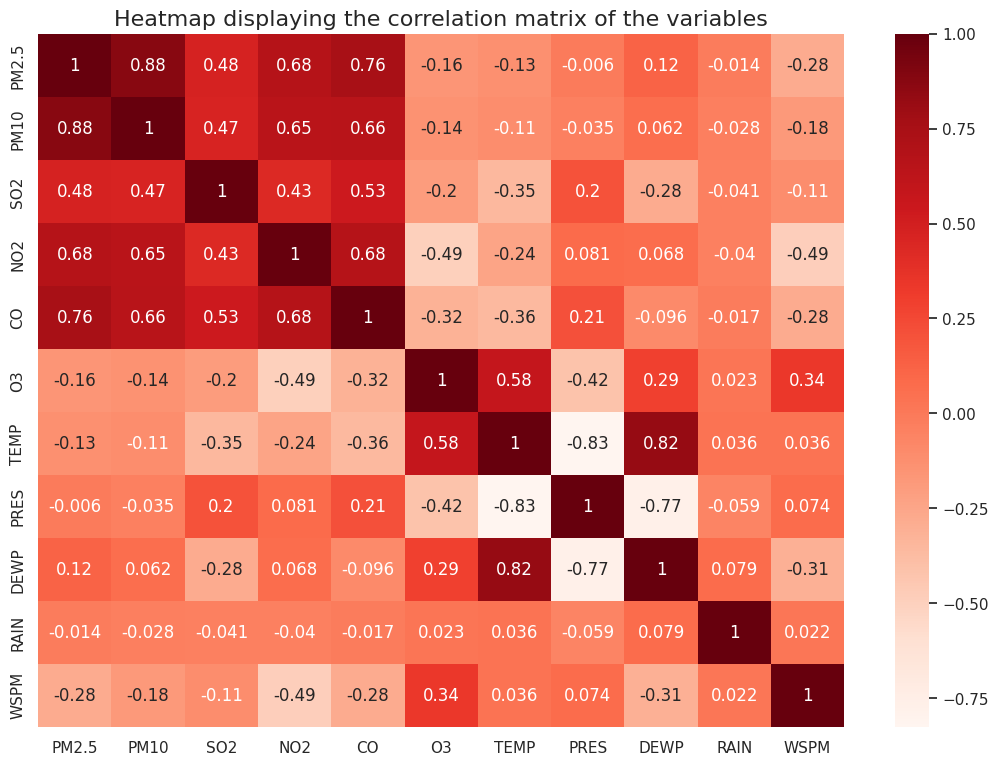

In [25]:
plt.figure(figsize=(13,9))
correlation_data = train_df[['PM2.5', 'PM10', 'SO2', 'NO2',
                         'CO', 'O3', 'TEMP', 'PRES',
                         'DEWP', 'RAIN', 'WSPM']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

In [26]:
cols_to_drop = ['date','year','month','day','hour','wd']
newdata = train_df.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const    35265.334328
PM2.5        6.459081
PM10         4.862474
SO2          1.680864
NO2          3.338790
CO           3.194612
O3           2.294924
TEMP         8.268337
PRES         3.646341
DEWP         6.515947
RAIN         1.023017
WSPM         1.800386
dtype: float64

In [27]:
newdata = newdata.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const    33435.775340
PM2.5        6.064912
PM10         4.752224
SO2          1.568787
NO2          3.333118
CO           3.169450
O3           2.208042
TEMP         4.594141
PRES         3.445564
RAIN         1.008987
WSPM         1.477082
dtype: float64

In [28]:
cols_to_drop = ['year','month','day','hour','wd']
new_test_data = test_df.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(new_test_data)
series_before_test = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before_test

const    36224.797831
PM2.5        3.253529
SO2          1.657984
NO2          3.191586
CO           3.021376
O3           2.206722
TEMP         8.445326
PRES         3.618296
DEWP         6.525914
RAIN         1.059683
WSPM         1.767000
dtype: float64

In [29]:
new_test_data = new_test_data.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(new_test_data)
series_after_test = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after_test

const    34715.866521
PM2.5        3.108474
SO2          1.544835
NO2          3.191536
CO           3.003672
O3           2.124480
TEMP         4.554658
PRES         3.457830
RAIN         1.015786
WSPM         1.389168
dtype: float64

In [30]:
X = newdata.drop('PM10',axis=1)
y = newdata['PM10']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,RAIN,WSPM
0,-0.962824,-0.588894,-1.417090,-0.801577,0.363633,-1.266510,1.085686,-0.073539,2.245135
1,-0.913859,-0.588894,-1.417090,-0.801577,0.363633,-1.301700,1.104950,-0.073539,2.495063
2,-0.926100,-0.544813,-1.335780,-0.801577,0.293402,-1.301700,1.133846,-0.073539,3.244844
3,-0.938341,-0.280323,-1.308677,-0.801577,0.275844,-1.328092,1.230166,-0.073539,1.162117
4,-0.975065,-0.236241,-1.281574,-0.801577,0.275844,-1.380877,1.297591,-0.073539,0.245718


In [31]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

In [32]:
print('Score on train data: {}\n'.format(lin_model.score(X_train,y_train)))
print('Score on test data: {}'.format(lin_model.score(X_test,y_test)))

Score on train data: 0.7928915828459279

Score on test data: 0.7761960082785586


In [33]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(accuracy))

Mean Squared Error: 2031.5503200981052

Overall model accuracy: 0.7761960082785586


In [34]:
ensemble_data = train_df.drop(cols_to_drop,axis=True)

In [35]:
ensemble_data.head()

,date,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
1,2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2,2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
3,2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
4,2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0


In [36]:
ensemble_data=ensemble_data.drop(['date'],axis=True)

In [37]:
ensemble_data.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0


In [38]:
X = ensemble_data.drop('PM10',axis=True)
y = ensemble_data['PM10']

In [39]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

In [40]:
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=3)

In [43]:
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.8014166404304537

Score on test data: 0.7586199718793549

Root Mean Squared Error: 49.22824398189032

Overall model accuracy: 0.7586199718793549


In [44]:
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [45]:
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.8364983640351097

Score on test data: 0.7889825824911083

Best parameters found:


{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 2}

Root Mean Squared Error: 46.02807683945008

Overall model accuracy: 0.7889825824911083


In [46]:
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                      min_samples_split=7)

In [47]:
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.8557793411923519

Score on test data: 0.8111421073760029

Root Mean Squared Error: 43.54429336418929

Overall model accuracy: 0.8111421073760029


In [48]:
params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [49]:
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.8483518753746266

Score on test data: 0.8097063986223252

Best parameters found:


{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 7}

Root Mean Squared Error: 43.70949312747108

Overall model accuracy: 0.8097063986223252


In [50]:
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                          min_samples_split=7)

In [51]:
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9258018771180253

Score on test data: 0.8569327100817399

Root Mean Squared Error: 37.89953249695091

Overall model accuracy: 0.8569327100817399


In [52]:
params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [53]:
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.96601148044742

Score on test data: 0.8578187874045646

Best parameters found:


{'n_estimators': 500,
 'min_samples_split': 7,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 6,
 'learning_rate': 0.2}

Root Mean Squared Error: 37.78198614945156

Overall model accuracy: 0.8578187874045646


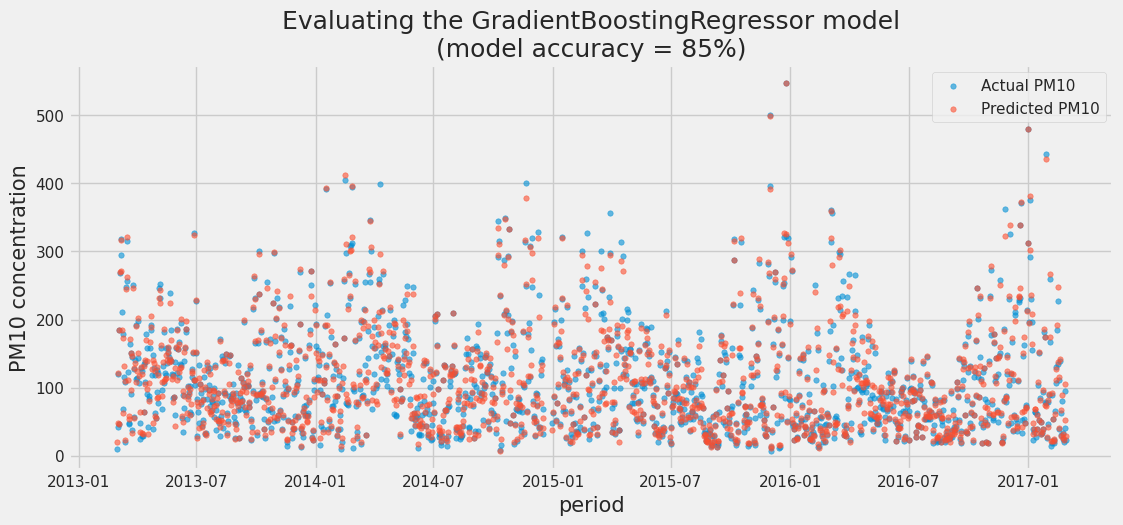

In [54]:
compare_data = pd.DataFrame({'dates':train_df['date'],
                            'Actual PM10':y,
                            'Predicted PM10':gboost_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM10'] = np.round(compare_data['Predicted PM10'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM10'],s=15,label='Actual PM10',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM10'],s=15,label='Predicted PM10',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model\n(model accuracy = 85%)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM10 concentration',fontsize=15)
    plt.show()

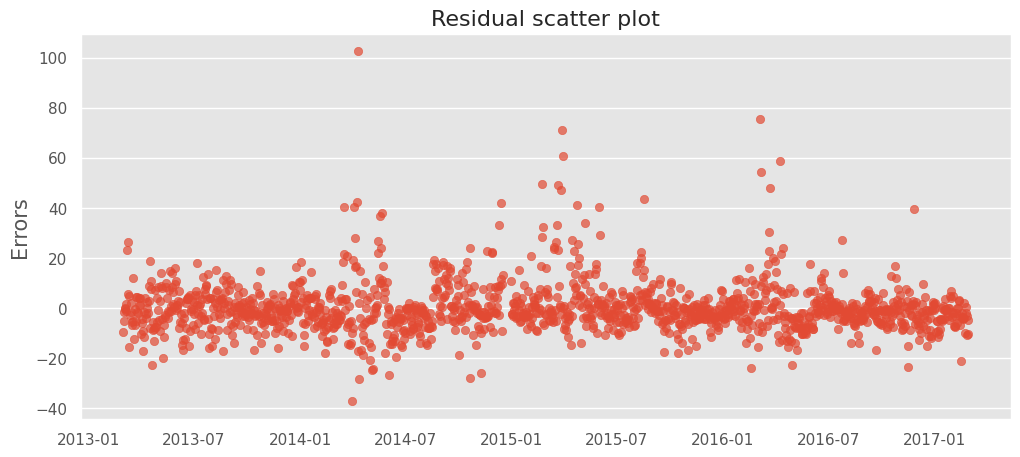

In [55]:
compare_data['Residuals'] = compare_data['Actual PM10'] - compare_data['Predicted PM10']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=16)
    plt.ylabel('Errors',fontsize=15)
    plt.grid(axis='x')
    plt.show()

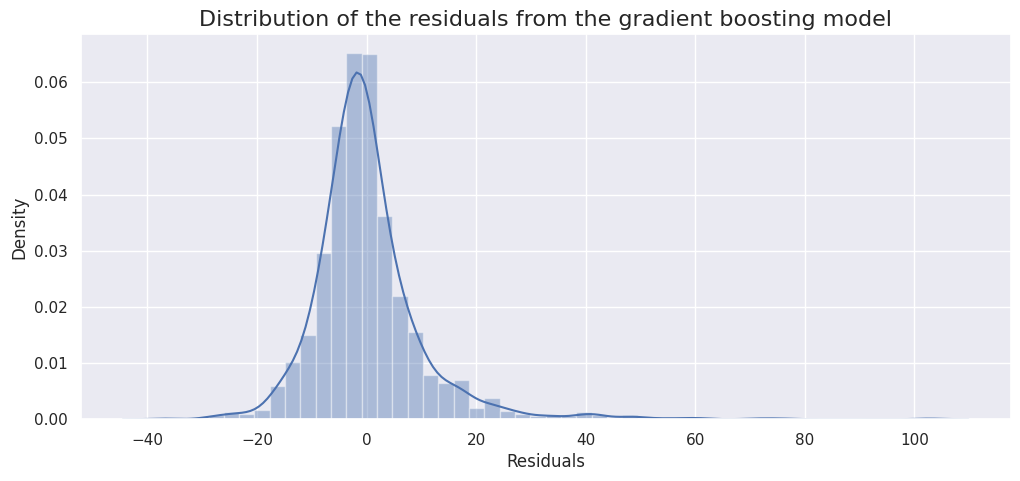

In [56]:
plt.figure(figsize=(12,5))
sns.distplot(compare_data.Residuals,bins=50)
plt.title('Distribution of the residuals from the gradient boosting model',
         fontsize=16)
plt.show()

In [57]:
pip install joblib

In [58]:
import joblib
joblib.dump(gboost_search, 'gboost_search.pkl')

['gboost_search.pkl']

In [59]:
test_df.head()

,year,month,day,hour,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013,3,1,18,11.0,8.0,20.000000,500.0,70.0,3.1,1027.4,-18.4,0.0,NNE,2.1
1,2013,3,2,13,25.0,20.0,57.000000,700.0,39.0,3.3,1025.7,-16.4,0.0,W,1.5
2,2013,3,3,13,98.0,50.0,81.000000,1200.0,33.0,16.0,1011.5,-13.5,0.0,W,5.9
3,2013,3,4,4,7.0,14.0,60.696625,400.0,42.0,6.0,1018.0,-11.6,0.0,NNW,1.0
4,2013,3,5,9,114.0,114.0,92.000000,2899.0,84.0,7.7,1012.8,-8.4,0.0,NNE,1.5


In [60]:
print('Are there any duplicated values in our data ? : {}\n'.format(test_df.duplicated().any()))
print('The total number of null values in each colum:')
display(test_df.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


year     0
month    0
day      0
hour     0
PM2.5    0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64

In [61]:
test_df.wd.mode()

0    NE
Name: wd, dtype: object

In [62]:
# Fill missing values for numerical columns only
numeric_cols = test_df.select_dtypes(include=['number']).columns
test_df[numeric_cols] = test_df[numeric_cols].fillna(value=test_df[numeric_cols].mean())

# Replace missing values for wind direction with the modal value
test_df.wd.fillna(value='NE',inplace=True)

# Check for remaining missing values
test_df.isnull().any()

year     False
month    False
day      False
hour     False
PM2.5    False
SO2      False
NO2      False
CO       False
O3       False
TEMP     False
PRES     False
DEWP     False
RAIN     False
wd       False
WSPM     False
dtype: bool

In [63]:
column_to_drop_test = ['year','month','day','hour','wd']

In [64]:
test_df = test_df.drop(column_to_drop_test,axis=True)

In [65]:
test_df.head()

,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,11.0,8.0,20.000000,500.0,70.0,3.1,1027.4,-18.4,0.0,2.1
1,25.0,20.0,57.000000,700.0,39.0,3.3,1025.7,-16.4,0.0,1.5
2,98.0,50.0,81.000000,1200.0,33.0,16.0,1011.5,-13.5,0.0,5.9
3,7.0,14.0,60.696625,400.0,42.0,6.0,1018.0,-11.6,0.0,1.0
4,114.0,114.0,92.000000,2899.0,84.0,7.7,1012.8,-8.4,0.0,1.5


In [67]:
model = joblib.load(open('gboost_search.pkl', 'rb'))
a=model.predict(test_df)

In [68]:
a

array([ 26.57436758,  43.95420065, 139.10529282, ...,  20.31067413,
        38.18133538,  26.93841963])

In [69]:
a=pd.DataFrame(a)

In [74]:
a

,0
0,26.574368
1,43.954201
2,139.105293
3,24.980069
4,176.709279
...,...
1298,14.554384
1299,38.656524
1300,20.310674
1301,38.181335


In [75]:
a.rename(columns = {0:'PM10'}, inplace = True)

In [76]:
a

,PM10
0,26.574368
1,43.954201
2,139.105293
3,24.980069
4,176.709279
...,...
1298,14.554384
1299,38.656524
1300,20.310674
1301,38.181335


In [77]:
a.to_csv('Output.csv', index=False)